In [28]:

import time
import pandas as pd 
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MaxAbsScaler, maxabs_scale, OrdinalEncoder, LabelEncoder
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE,ADASYN
from sklearn.feature_selection import chi2
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, precision_recall_fscore_support, classification_report,confusion_matrix
from sklearn.feature_selection import SelectKBest, chi2, f_classif
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier
import xgboost as xgb
from xgboost import plot_importance
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import plot_tree
import matplotlib.pyplot as plt 
import numpy as np

In [9]:
df = pd.read_csv("dataset_preprocessed.csv", parse_dates=['event_date'])
df['event_description'].fillna(value='', inplace=True)
df.columns

Index(['event_date', 'event_title', 'event_description', 'location_description', 'location_accuracy', 'landslide_category', 'landslide_trigger', 'landslide_size', 'landslide_setting', 'fatality_count', 'injury_count', 'country_name', 'admin_division_name', 'admin_division_population', 'gazeteer_closest_point', 'gazeteer_distance', 'longitude', 'latitude', 'tempmax', 'tempmin', 'temp', 'feelslikemax', 'feelslikemin', 'feelslike', 'dew', 'humidity', 'precip', 'precipcover', 'windgust', 'windspeed', 'winddir', 'pressure', 'cloudcover', 'visibility', 'moonphase', 'conditions', 'stations', 'elevation', 'continent', 'season', 'treecover2000', 'loss', 'gain', 'soil_texture_0', 'soil_texture_10', 'soil_texture_30', 'soil_texture_60', 'soil_texture_100', 'soil_texture_200', 'population_density_2000', 'population_density_2005', 'population_density_2010', 'population_density_2015', 'population_density_2020'], dtype='object')

In [10]:
df.drop(['admin_division_population','population_density_2000', 'population_density_2005', 'population_density_2010', 'population_density_2015'], axis="columns", inplace=True)

In [67]:
def preprocessing(df_temp):
    dfs = df_temp.copy(deep = True)
    ft = dfs.columns.difference(["landslide_size"])
    category_ft = dfs.select_dtypes(exclude=np.number).columns

    enc = OrdinalEncoder()
    enc.fit(dfs[category_ft])
    dfs[category_ft] = enc.transform(dfs[category_ft])

    labelencoder = LabelEncoder()
    dfs["landslide_size"] = labelencoder.fit_transform(dfs["landslide_size"])

    X = dfs[ft]
    y = dfs["landslide_size"]
    
    X_train, X_test, y_train, y_test = train_test_split(X,y, train_size = 0.8, test_size = 0.2, random_state = 0,stratify = y)
    
    # Scale features
    scaler = MaxAbsScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    # df_train[df_train.select_dtypes(include=np.number).columns] = df_train[df_train.select_dtypes(include=np.number).columns].apply(
    #     lambda x: (x - x.min()) / (x.max()-x.min()))
    # df_test[df_train.select_dtypes(include=np.number).columns] = df_test[df_train.select_dtypes(include=np.number).columns].apply(
    #     lambda x: (x - x.min()) / (x.max()-x.min()))
    # Fill empty values by 0
    return X_train, X_test, y_train, y_test

In [123]:

def train(X_train, y_train, X_test, y_test):
    dt = DecisionTreeClassifier(random_state = 0)
    dt.fit(X_train,y_train) 
    dt_score=dt.score(X_test,y_test)
    dt_y_predict=dt.predict(X_test)
    y_true=y_test
    print('Accuracy of DT: '+ str(dt_score))
    dt_precision,dt_recall,dt_fscore,none= precision_recall_fscore_support(y_true, dt_y_predict, average='weighted') 
    print('Precision of DT: '+(str(dt_precision)))
    print('Recall of DT: '+(str(dt_recall)))
    print('F1-score of DT: '+(str(dt_fscore)))
    print(classification_report(y_true,dt_y_predict))
    cm=confusion_matrix(y_true,dt_y_predict)
    f,ax=plt.subplots(figsize=(5,5))
    sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
    plt.xlabel("y_pred")
    plt.ylabel("y_true")
    plt.show()

    dt_train=dt.predict(X_train)
    dt_test=dt.predict(X_test)

    rf = RandomForestClassifier(random_state = 0)
    rf.fit(X_train,y_train) # modelin veri üzerinde öğrenmesi fit fonksiyonuyla yapılıyor
    rf_score=rf.score(X_test,y_test)
    rf_y_predict=rf.predict(X_test)
    y_true=y_test
    print('Accuracy of RF: '+ str(rf_score))
    rf_precision,rf_recall,rf_fscore,none= precision_recall_fscore_support(y_true, rf_y_predict, average='weighted') 
    print('Precision of RF: '+(str(rf_precision)))
    print('Recall of RF: '+(str(rf_recall)))
    print('F1-score of RF: '+(str(rf_fscore)))
    print(classification_report(y_true,rf_y_predict))
    cm=confusion_matrix(y_true,rf_y_predict)
    f,ax=plt.subplots(figsize=(5,5))
    sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
    plt.xlabel("y_pred")
    plt.ylabel("y_true")
    plt.show()

    rf_train=rf.predict(X_train)
    rf_test=rf.predict(X_test)

    et = ExtraTreesClassifier(random_state = 0)
    et.fit(X_train,y_train) 
    et_score=et.score(X_test,y_test)
    et_y_predict=et.predict(X_test)
    y_true=y_test
    print('Accuracy of ET: '+ str(et_score))
    et_precision,et_recall,et_fscore,none= precision_recall_fscore_support(y_true,et_y_predict, average='weighted') 
    print('Precision of ET: '+(str(et_precision)))
    print('Recall of ET: '+(str(et_recall)))
    print('F1-score of ET: '+(str(et_fscore)))
    print(classification_report(y_true,et_y_predict))
    cm=confusion_matrix(y_true,et_y_predict)
    f,ax=plt.subplots(figsize=(5,5))
    sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
    plt.xlabel("y_pred")
    plt.ylabel("y_true")
    plt.show()

    et_train=et.predict(X_train)
    et_test=et.predict(X_test)

    xg = xgb.XGBClassifier(n_estimators = 10)
    xg.fit(X_train,y_train)
    xg_score=xg.score(X_test,y_test)
    xg_y_predict=xg.predict(X_test)
    y_true=y_test
    print('Accuracy of XGBoost: '+ str(xg_score))
    xg_precision,xg_recall,xg_fscore,none= precision_recall_fscore_support(y_true, xg_y_predict, average='weighted') 
    print('Precision of XGBoost: '+(str(xg_precision)))
    print('Recall of XGBoost: '+(str(xg_recall)))
    print('F1-score of XGBoost: '+(str(xg_fscore)))
    print(classification_report(y_true,xg_y_predict))
    cm=confusion_matrix(y_true,xg_y_predict)
    f,ax=plt.subplots(figsize=(5,5))
    sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
    plt.xlabel("y_pred")
    plt.ylabel("y_true")
    plt.show()

    xg_train=xg.predict(X_train)
    xg_test=xg.predict(X_test)

    base_predictions_train = pd.DataFrame( {
    'DecisionTree': dt_train.ravel(),
        'RandomForest': rf_train.ravel(),
     'ExtraTrees': et_train.ravel(),
     'XgBoost': xg_train.ravel(),
    })
    print(base_predictions_train.head(5))

    dt_train=dt_train.reshape(-1, 1)
    et_train=et_train.reshape(-1, 1)
    rf_train=rf_train.reshape(-1, 1)
    xg_train=xg_train.reshape(-1, 1)
    dt_test=dt_test.reshape(-1, 1)
    et_test=et_test.reshape(-1, 1)
    rf_test=rf_test.reshape(-1, 1)
    xg_test=xg_test.reshape(-1, 1)

    x_train = np.concatenate(( dt_train, et_train, rf_train, xg_train), axis=1)
    x_test = np.concatenate(( dt_test, et_test, rf_test, xg_test), axis=1)  
    
    stk = xgb.XGBClassifier().fit(x_train, y_train)
    stk_y_predict=stk.predict(x_test)
    y_true=y_test
    stk_score=accuracy_score(y_true,stk_y_predict)
    print('Accuracy of Stacking: '+ str(stk_score))
    stk_precision,stk_recall,stk_fscore,none= precision_recall_fscore_support(y_true, stk_y_predict, average='weighted') 
    print('Precision of Stacking: '+(str(stk_precision)))
    print('Recall of Stacking: '+(str(stk_recall)))
    print('F1-score of Stacking: '+(str(stk_fscore)))
    print(classification_report(y_true,stk_y_predict))
    cm=confusion_matrix(y_true,stk_y_predict)
    f,ax=plt.subplots(figsize=(5,5))
    sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
    plt.xlabel("y_pred")
    plt.ylabel("y_true")
    plt.show()
    # plot_tree(stk)
    # plt.show()

    accuracy  = [dt_score, rf_score, et_score, xg_score, stk_score]
    precision = [dt_precision, rf_precision, et_precision, xg_precision, stk_precision]
    recall = [dt_recall, rf_recall, et_recall, xg_recall, stk_recall]
    f1_score = [dt_fscore, rf_fscore, et_fscore, xg_fscore, stk_fscore]
    for i in [accuracy, precision,recall, f1_score]:
        for j in range(0,5):
            i[j] = i[j]*100
    model = ['Decision Tree', 'Random Forest','Extra Tree','XGBoost',"XGBoost Stacking Model"]
    
    fig = plt.figure(figsize=(30, 10))
    plt.plot(model, accuracy) 
    plt.plot(model, precision)
    plt.plot(model, recall)
    plt.plot(model, f1_score)
    plt.xlabel("Models")  # add X-axis label 
    plt.ylabel("Percent")  # add Y-axis label 
    plt.title("Models score chart")  # add title 
    # plt.xticks(rotation=30, ha='right')
    plt.legend(['Accuracy', 'Precision','Recall','Fscore']) 
    plt.show() 

    df_score = pd.DataFrame({'Model': [], 'Accuracy': [], 'Precision': [],'Recall': [],'fscore': []})
    df_score["Model"] = pd.Series(model)
    df_score["Accuracy"] = pd.Series(accuracy)
    df_score["Precision"] = pd.Series(precision)
    df_score["Recall"] = pd.Series(recall)
    df_score["fscore"] = pd.Series(f1_score)
    print(df_score)
    # fig = plt.figure(figsize=(30,20))
    # for i in range(len(numeric_ft)):
    #     ax = plt.subplot(4, 9, i+1)
    #     sns.distplot(df[numeric_ft[i]], kde=True, rug=True, ax=ax)
    
    return dt.feature_importances_, rf.feature_importances_, et.feature_importances_, xg.feature_importances_   

In [126]:
def ft_selection(df_temp, dt_feature, rf_feature, et_feature, xgb_feature):
    
    dfs = df_temp.copy(deep = True)

    ft = dfs.columns.difference(["landslide_size"])
    # calculate the average importance value of each feature
    avg_feature = (dt_feature + rf_feature + et_feature + xgb_feature)/4

    print ("Features sorted by their score:")
    print (sorted(zip(map(lambda x: round(x, 4), avg_feature), ft), reverse=True))

    f_list = sorted(zip(map(lambda x: round(x, 4), avg_feature), ft), reverse=True)
    print(len(f_list))

    # Select the important features from top-importance to bottom-importance until the accumulated importance reaches 0.9 (out of 1)
    Sum = 0
    fs = []
    for i in range(0, len(f_list)):
        Sum = Sum + f_list[i][0]
        fs.append(f_list[i][1])
        if Sum>=0.9:
            break   
    
     
  
    fig = plt.figure(figsize=(30, 10))
    plt.plot(ft, dt_feature, linestyle = 'dashed') 
    plt.plot(ft, rf_feature, linestyle = 'dashed')
    plt.plot(ft, et_feature, linestyle = 'dashed')
    plt.plot(ft, xgb_feature, linestyle = 'dashed')
    plt.plot(ft, avg_feature, linewidth = '10')
    plt.xlabel("Features")  # add X-axis label 
    plt.ylabel("Importance score")  # add Y-axis label 
    plt.title("Immportnace score chart")  # add title 
    plt.xticks(rotation=30, ha='right')
    plt.legend(['Decision Tree Importance Score', 'Random Forest Importance Score','Extra Tree Importance Score','XGBoost Importance Score',"XGBoost Stacking Model"]) 
    plt.show() 
    
    return fs
    # category_ft = dfs.select_dtypes(exclude=np.number).columns
    # enc = OrdinalEncoder()
    # enc.fit(dfs[category_ft])
    # dfs[category_ft] = enc.transform(dfs[category_ft])

    # labelencoder = LabelEncoder()
    # dfs["landslide_size"] = labelencoder.fit_transform(dfs["landslide_size"])
    
    

    # scaler = MaxAbsScaler()
    # X_train = scaler.fit_transform(X_train)
    # X_test = scaler.transform(X_test)

    # print(y_train.value_counts())
    # print(y_test.value_counts())
    # print (fs, len(fs))
    # print(y_train)
    
    # return X_train, y_train, X_test, y_test


Accuracy of DT: 0.6543606206527555
Precision of DT: 0.6659513362344942
Recall of DT: 0.6543606206527555
F1-score of DT: 0.659638950652257
              precision    recall  f1-score   support

           1       0.25      0.32      0.28       118
           2       0.74      0.70      0.72      1074
           3       0.55      0.57      0.56       504
           4       0.93      0.90      0.92       157
           5       0.05      0.06      0.06        16

    accuracy                           0.65      1869
   macro avg       0.50      0.51      0.51      1869
weighted avg       0.67      0.65      0.66      1869



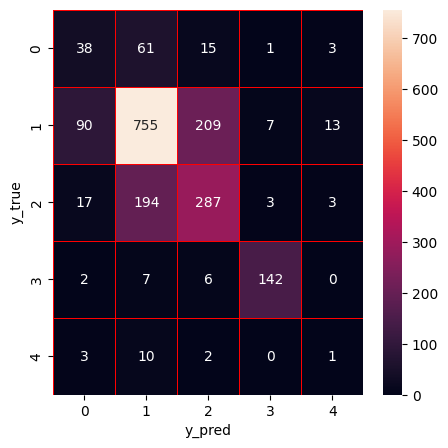

Accuracy of RF: 0.7303370786516854
Precision of RF: 0.7190051400992759
Recall of RF: 0.7303370786516854
F1-score of RF: 0.710398217998252
              precision    recall  f1-score   support

           1       0.65      0.14      0.24       118
           2       0.73      0.86      0.79      1074
           3       0.64      0.56      0.60       504
           4       0.99      0.90      0.94       157
           5       0.00      0.00      0.00        16

    accuracy                           0.73      1869
   macro avg       0.60      0.49      0.51      1869
weighted avg       0.72      0.73      0.71      1869



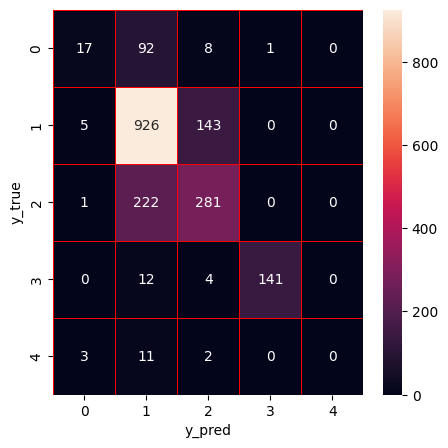

Accuracy of ET: 0.7212413055109684
Precision of ET: 0.6938994017914215
Recall of ET: 0.7212413055109684
F1-score of ET: 0.6923913492720599
              precision    recall  f1-score   support

           1       0.38      0.03      0.05       118
           2       0.72      0.87      0.79      1074
           3       0.64      0.54      0.59       504
           4       1.00      0.90      0.95       157
           5       0.00      0.00      0.00        16

    accuracy                           0.72      1869
   macro avg       0.55      0.47      0.47      1869
weighted avg       0.69      0.72      0.69      1869



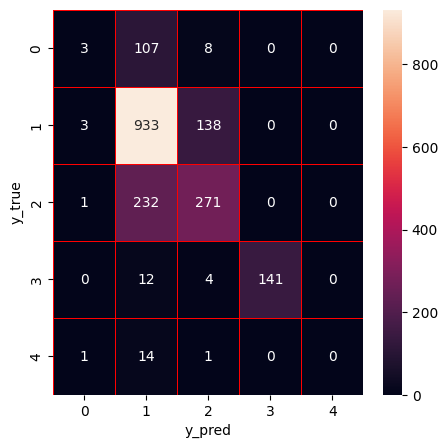

Accuracy of XGBoost: 0.7421080791867308
Precision of XGBoost: 0.7295412221216996
Recall of XGBoost: 0.7421080791867308
F1-score of XGBoost: 0.7276745483756473
              precision    recall  f1-score   support

           1       0.52      0.14      0.23       118
           2       0.76      0.84      0.80      1074
           3       0.65      0.64      0.65       504
           4       0.99      0.90      0.94       157
           5       0.12      0.06      0.08        16

    accuracy                           0.74      1869
   macro avg       0.61      0.52      0.54      1869
weighted avg       0.73      0.74      0.73      1869



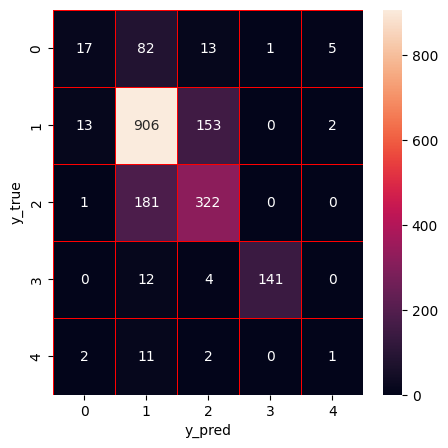

   DecisionTree  RandomForest  ExtraTrees  XgBoost
0             2             2           2        2
1             1             1           1        2
2             2             2           2        2
3             4             4           4        4
4             2             2           2        2
Accuracy of Stacking: 0.6543606206527555
Precision of Stacking: 0.6659513362344942
Recall of Stacking: 0.6543606206527555
F1-score of Stacking: 0.659638950652257
              precision    recall  f1-score   support

           1       0.25      0.32      0.28       118
           2       0.74      0.70      0.72      1074
           3       0.55      0.57      0.56       504
           4       0.93      0.90      0.92       157
           5       0.05      0.06      0.06        16

    accuracy                           0.65      1869
   macro avg       0.50      0.51      0.51      1869
weighted avg       0.67      0.65      0.66      1869



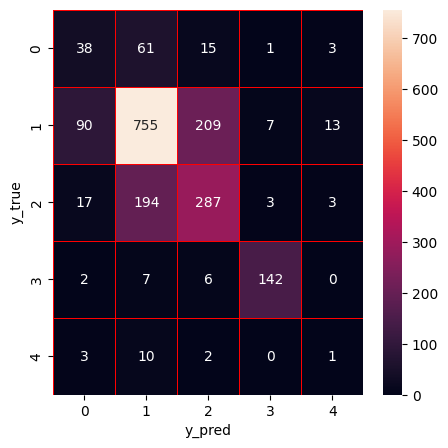

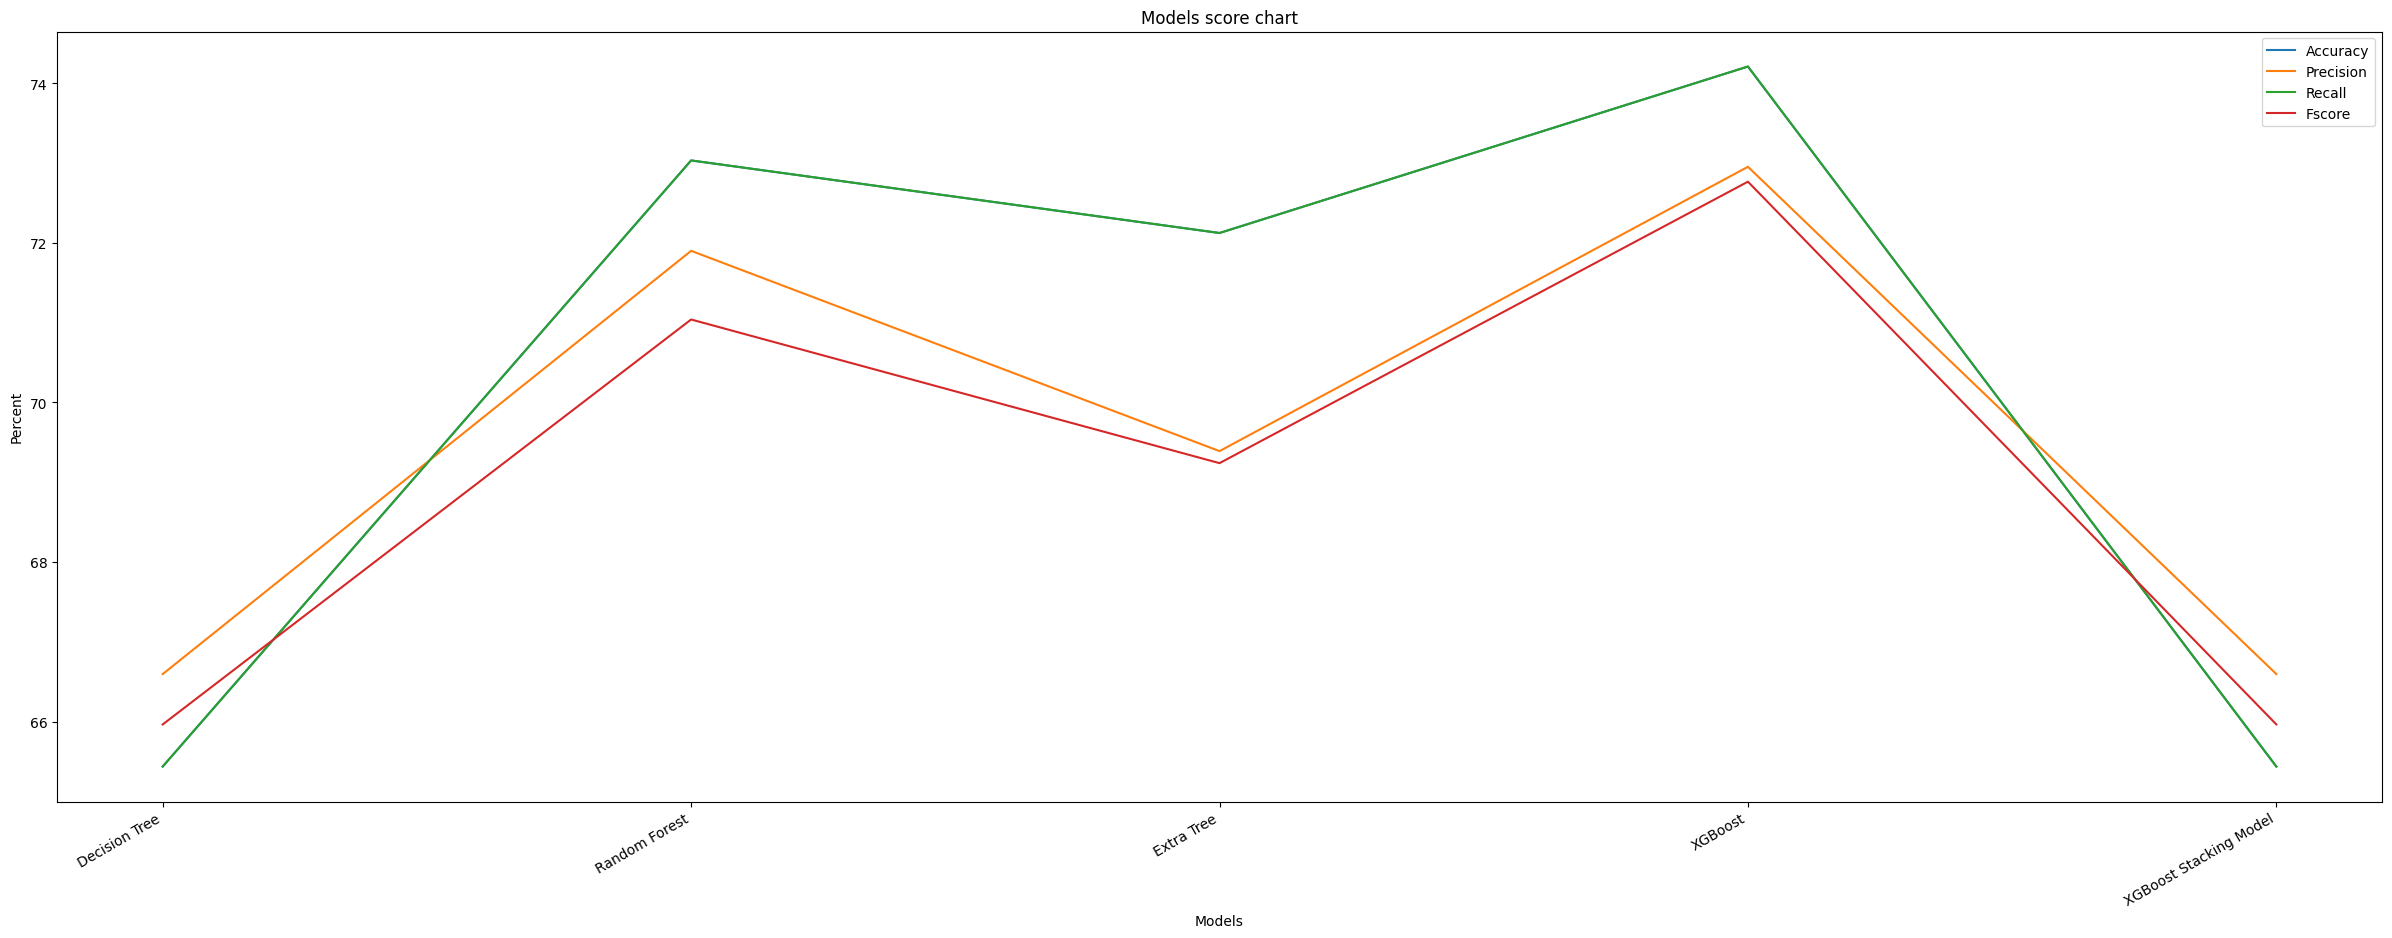

                    Model   Accuracy  Precision     Recall     fscore
0           Decision Tree  65.436062  66.595134  65.436062  65.963895
1           Random Forest  73.033708  71.900514  73.033708  71.039822
2              Extra Tree  72.124131  69.389940  72.124131  69.239135
3                 XGBoost  74.210808  72.954122  74.210808  72.767455
4  XGBoost Stacking Model  65.436062  66.595134  65.436062  65.963895


In [127]:
X_train, X_test, y_train, y_test =  preprocessing(df)
dt_feature, rf_feature, et_feature, xgb_feature = train(X_train, y_train, X_test, y_test)

Features sorted by their score:
[(0.1373, 'event_description'), (0.0673, 'country_name'), (0.0658, 'event_date'), (0.04, 'landslide_trigger'), (0.0361, 'longitude'), (0.0311, 'fatality_count'), (0.0296, 'latitude'), (0.0277, 'landslide_setting'), (0.0271, 'gazeteer_distance'), (0.023, 'population_density_2020'), (0.0228, 'location_accuracy'), (0.0206, 'elevation'), (0.0196, 'location_description'), (0.0188, 'admin_division_name'), (0.018, 'stations'), (0.0177, 'humidity'), (0.0177, 'dew'), (0.0176, 'windspeed'), (0.0176, 'event_title'), (0.0171, 'winddir'), (0.017, 'pressure'), (0.0166, 'moonphase'), (0.0163, 'tempmin'), (0.0163, 'gazeteer_closest_point'), (0.0163, 'continent'), (0.0162, 'cloudcover'), (0.0156, 'visibility'), (0.0151, 'precip'), (0.0149, 'feelslikemax'), (0.0147, 'feelslikemin'), (0.0146, 'feelslike'), (0.0144, 'tempmax'), (0.0144, 'temp'), (0.0138, 'landslide_category'), (0.0136, 'treecover2000'), (0.0134, 'precipcover'), (0.0117, 'windgust'), (0.0102, 'season'), (0.0

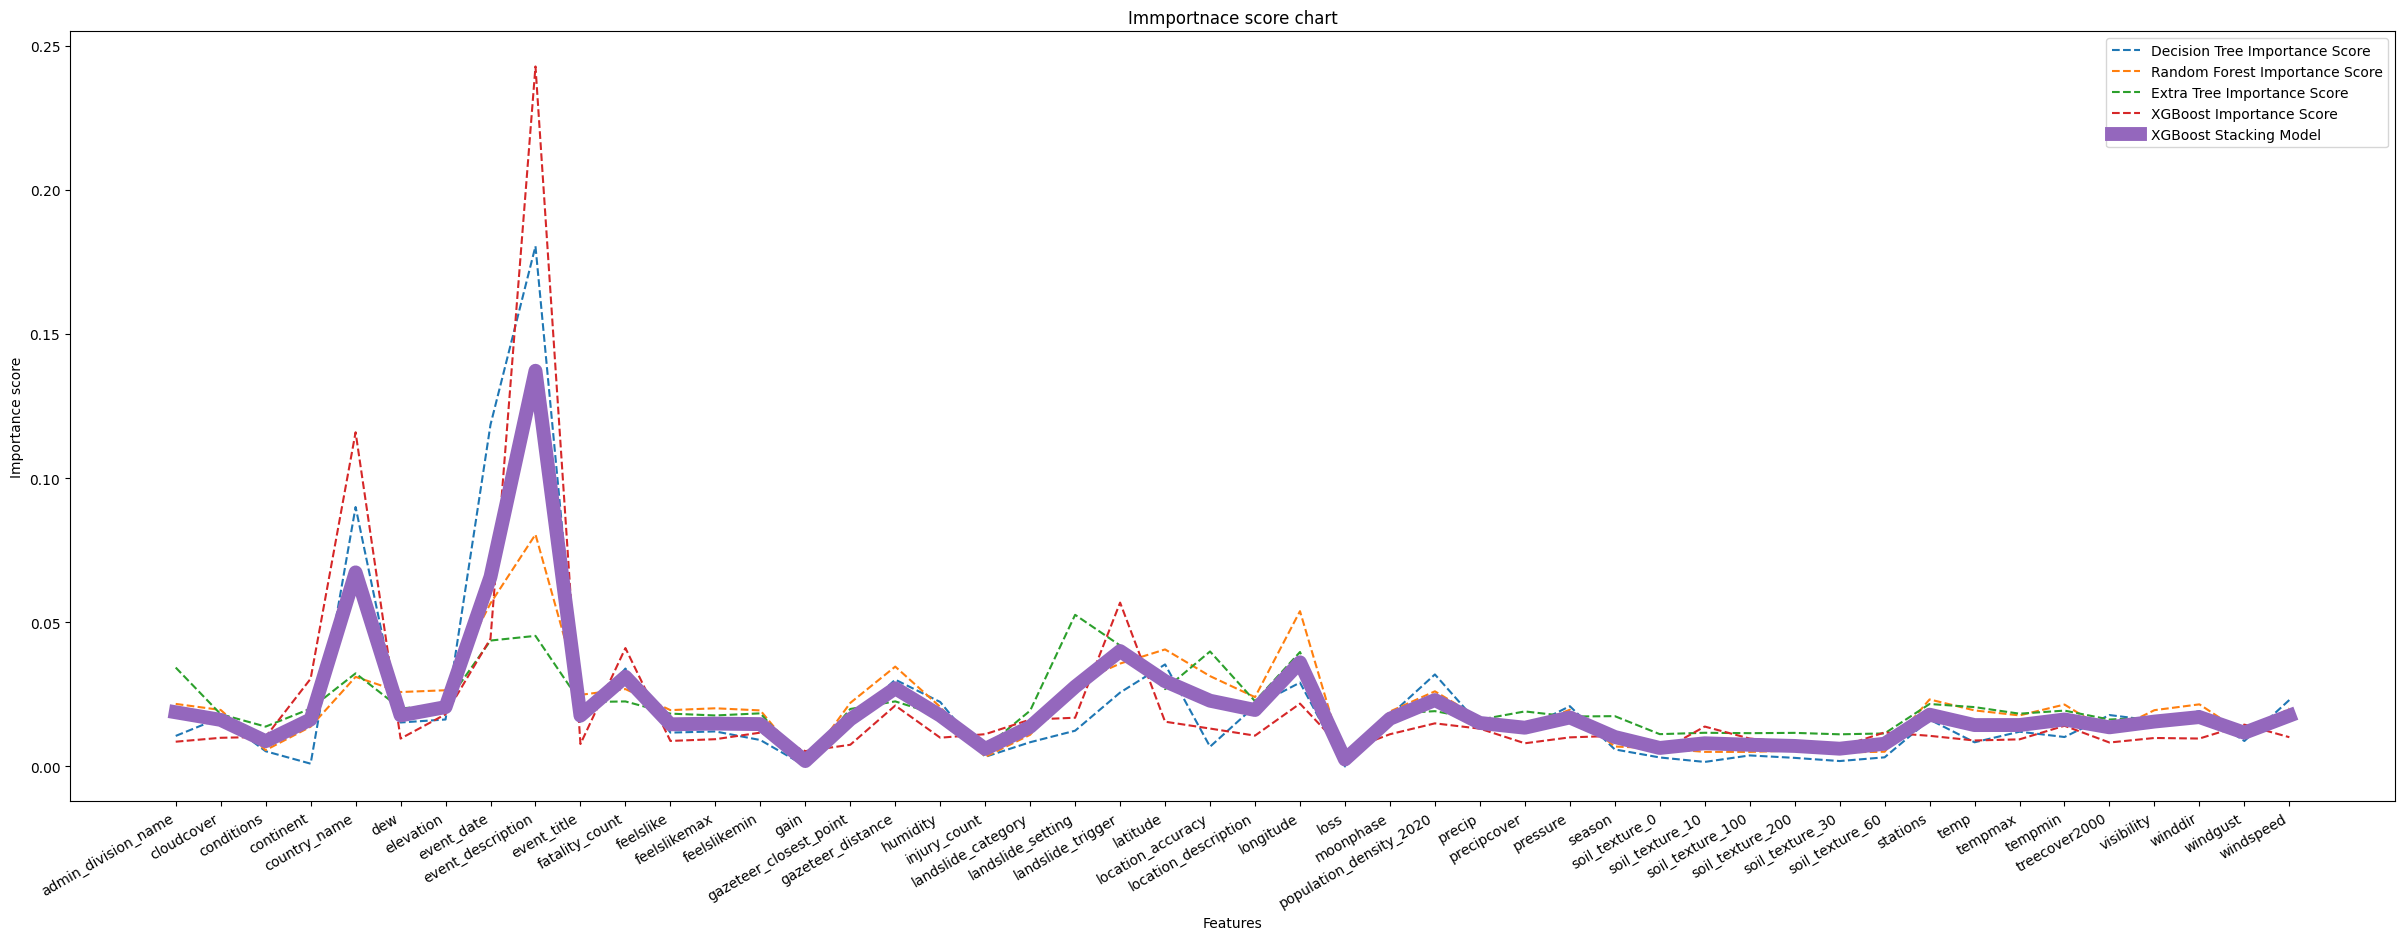

Accuracy of DT: 0.6704119850187266
Precision of DT: 0.6780416805272725
Recall of DT: 0.6704119850187266
F1-score of DT: 0.67397122904494
              precision    recall  f1-score   support

           1       0.25      0.29      0.27       118
           2       0.75      0.72      0.73      1074
           3       0.58      0.60      0.59       504
           4       0.91      0.90      0.90       157
           5       0.14      0.19      0.16        16

    accuracy                           0.67      1869
   macro avg       0.53      0.54      0.53      1869
weighted avg       0.68      0.67      0.67      1869



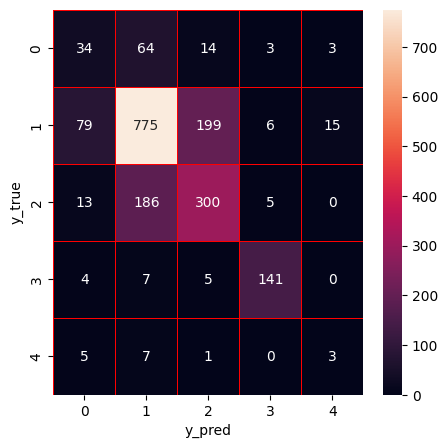

Accuracy of RF: 0.7372926698769395
Precision of RF: 0.7244377561014957
Recall of RF: 0.7372926698769395
F1-score of RF: 0.7199885050566911
              precision    recall  f1-score   support

           1       0.61      0.19      0.29       118
           2       0.74      0.86      0.80      1074
           3       0.66      0.57      0.61       504
           4       0.99      0.90      0.94       157
           5       0.00      0.00      0.00        16

    accuracy                           0.74      1869
   macro avg       0.60      0.50      0.53      1869
weighted avg       0.72      0.74      0.72      1869



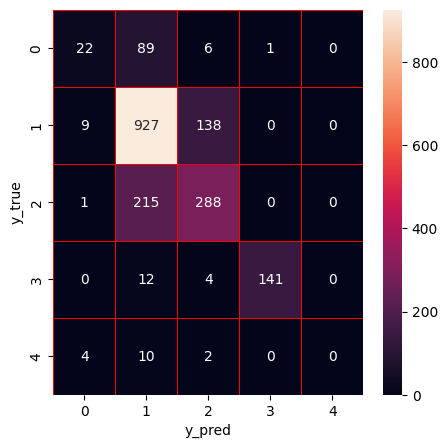

Accuracy of ET: 0.7287319422150883
Precision of ET: 0.7120083207323382
Recall of ET: 0.7287319422150883
F1-score of ET: 0.7026508882615367
              precision    recall  f1-score   support

           1       0.56      0.04      0.08       118
           2       0.73      0.86      0.79      1074
           3       0.65      0.58      0.61       504
           4       0.99      0.90      0.94       157
           5       0.00      0.00      0.00        16

    accuracy                           0.73      1869
   macro avg       0.58      0.48      0.48      1869
weighted avg       0.71      0.73      0.70      1869



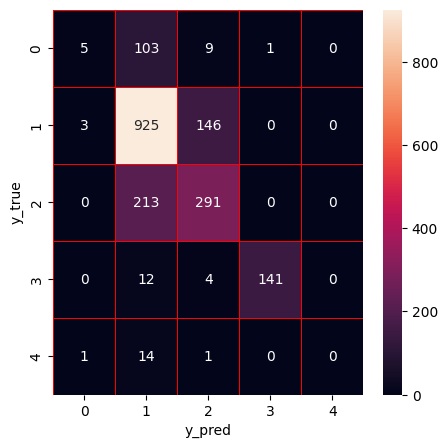

Accuracy of XGBoost: 0.7453183520599251
Precision of XGBoost: 0.7387530197646689
Recall of XGBoost: 0.7453183520599251
F1-score of XGBoost: 0.7328542090659294
              precision    recall  f1-score   support

           1       0.63      0.19      0.29       118
           2       0.76      0.85      0.80      1074
           3       0.65      0.63      0.64       504
           4       0.99      0.89      0.94       157
           5       0.20      0.12      0.15        16

    accuracy                           0.75      1869
   macro avg       0.65      0.54      0.57      1869
weighted avg       0.74      0.75      0.73      1869



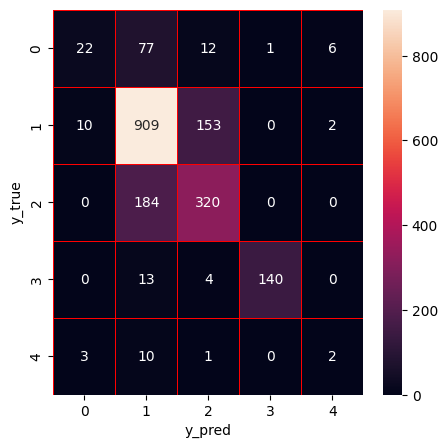

   DecisionTree  RandomForest  ExtraTrees  XgBoost
0             2             2           2        2
1             1             1           1        2
2             2             2           2        2
3             4             4           4        4
4             2             2           2        2
Accuracy of Stacking: 0.6704119850187266
Precision of Stacking: 0.6780416805272725
Recall of Stacking: 0.6704119850187266
F1-score of Stacking: 0.67397122904494
              precision    recall  f1-score   support

           1       0.25      0.29      0.27       118
           2       0.75      0.72      0.73      1074
           3       0.58      0.60      0.59       504
           4       0.91      0.90      0.90       157
           5       0.14      0.19      0.16        16

    accuracy                           0.67      1869
   macro avg       0.53      0.54      0.53      1869
weighted avg       0.68      0.67      0.67      1869



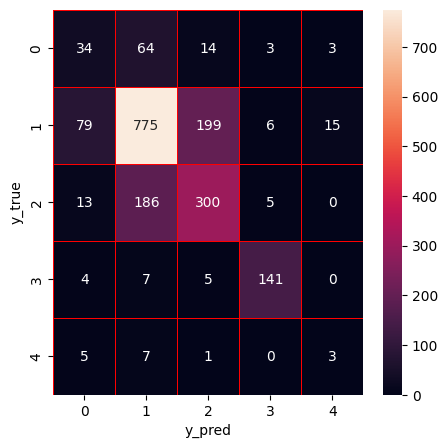

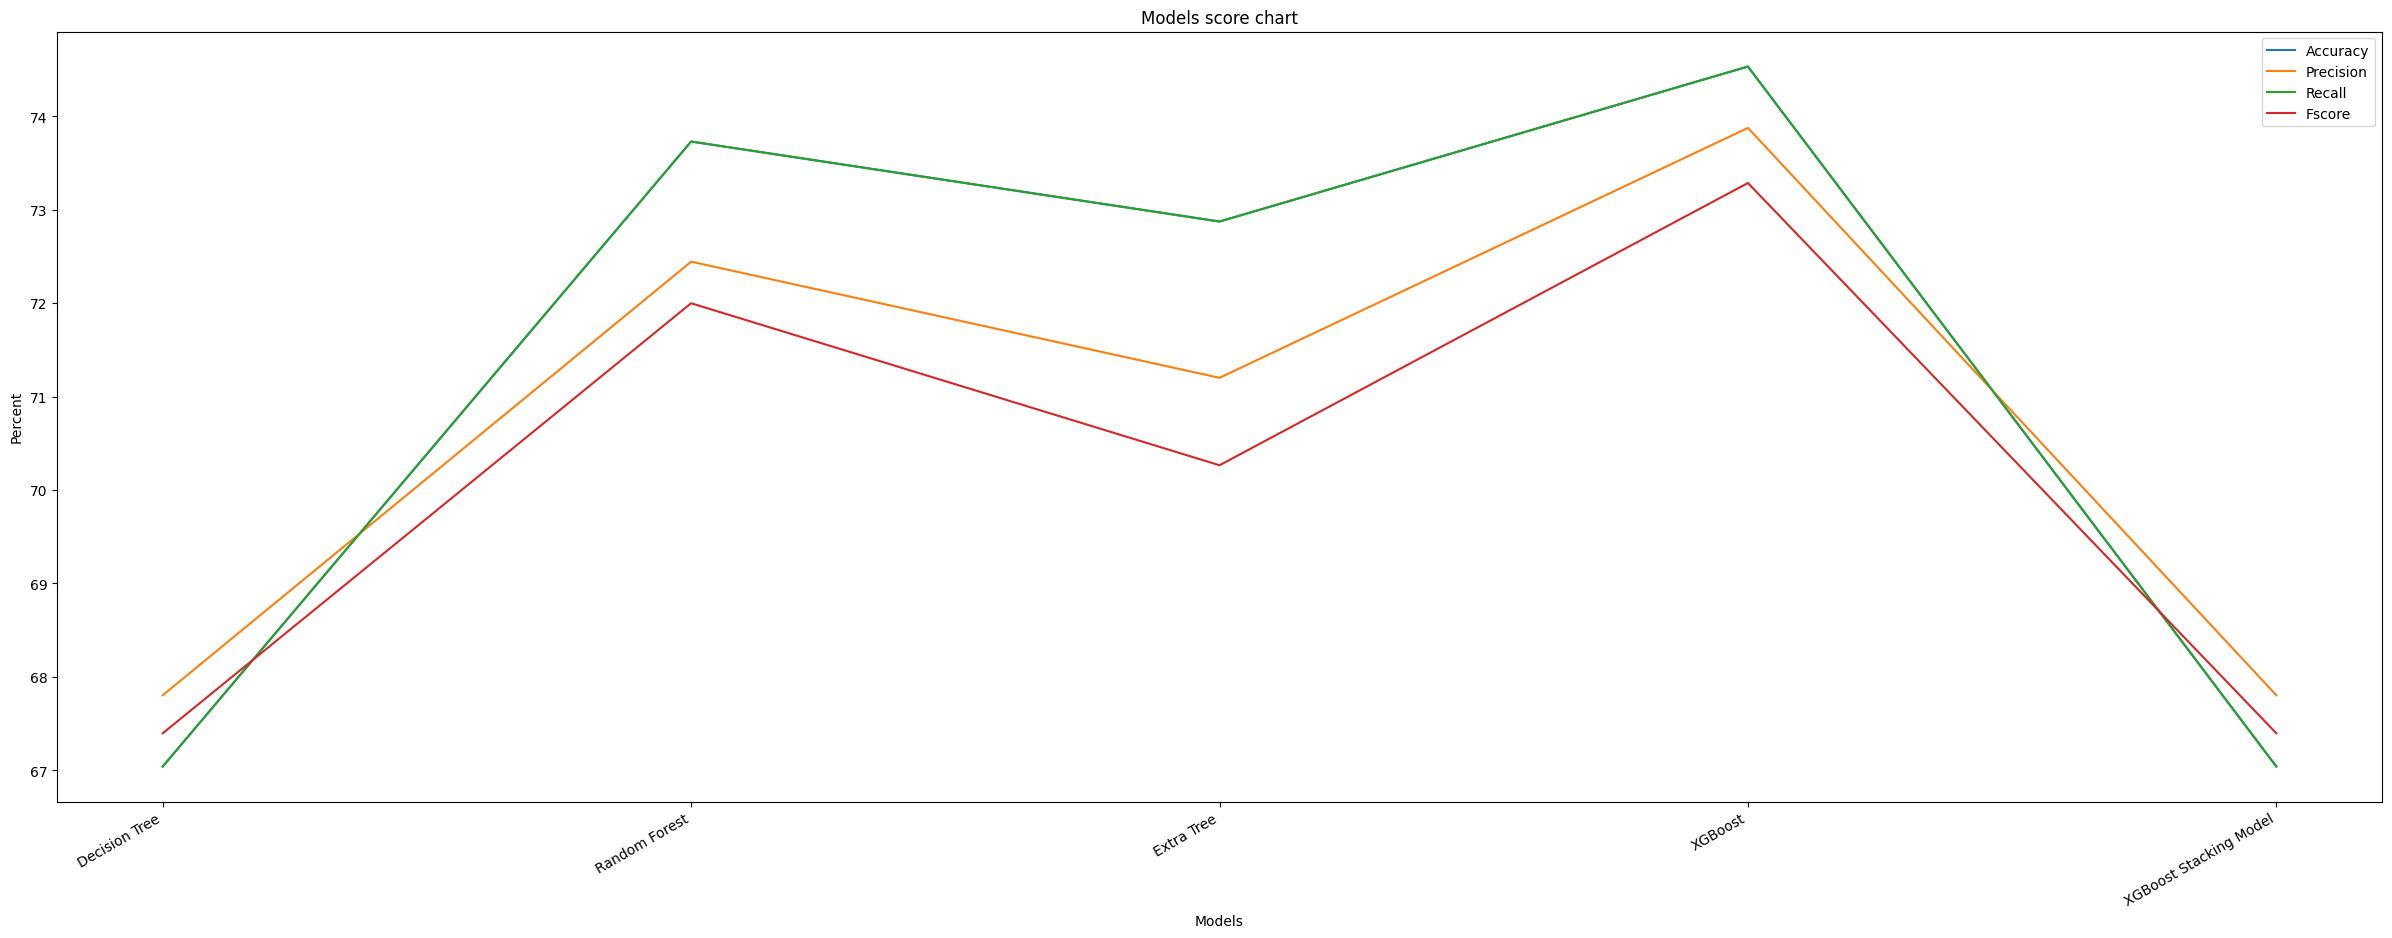

                    Model   Accuracy  Precision     Recall     fscore
0           Decision Tree  67.041199  67.804168  67.041199  67.397123
1           Random Forest  73.729267  72.443776  73.729267  71.998851
2              Extra Tree  72.873194  71.200832  72.873194  70.265089
3                 XGBoost  74.531835  73.875302  74.531835  73.285421
4  XGBoost Stacking Model  67.041199  67.804168  67.041199  67.397123


(array([0.18380564, 0.09060248, 0.11996017, 0.02549218, 0.02631189,
        0.03198772, 0.03499584, 0.01452995, 0.03059652, 0.03308124,
        0.01128069, 0.02308706, 0.02153518, 0.01235009, 0.01688464,
        0.02333068, 0.01763242, 0.02316245, 0.01856443, 0.02202375,
        0.02186043, 0.01979809, 0.01559351, 0.01727441, 0.00238391,
        0.01874842, 0.02031708, 0.0211495 , 0.0109067 , 0.00959653,
        0.01266898, 0.01270071, 0.00830161, 0.00945077, 0.01803434]),
 array([0.09277779, 0.03768062, 0.06013405, 0.03702771, 0.05379967,
        0.02930065, 0.04789813, 0.02906534, 0.03584998, 0.02730188,
        0.03024064, 0.0294649 , 0.02627956, 0.01980494, 0.02602362,
        0.02293384, 0.02608456, 0.02205302, 0.02614326, 0.02391532,
        0.02284502, 0.02100633, 0.0210568 , 0.0241393 , 0.01394906,
        0.02187383, 0.02287591, 0.01982444, 0.02118919, 0.02282806,
        0.02013202, 0.01982968, 0.01868194, 0.01294501, 0.01304392]),
 array([0.05780015, 0.03616582, 0.04877916, 

In [128]:
fs = ft_selection(df, dt_feature, rf_feature, et_feature, xgb_feature)

ft = df.columns.difference(["landslide_size"])
category_ft = df.select_dtypes(exclude=np.number).columns

enc = OrdinalEncoder()
enc.fit(df[category_ft])
df[category_ft] = enc.transform(df[category_ft])

labelencoder = LabelEncoder()
df["landslide_size"] = labelencoder.fit_transform(df["landslide_size"])

X_fs = df[fs].values     
y = df["landslide_size"]
    
X_train, X_test, y_train, y_test = train_test_split(X_fs,y, train_size = 0.8, test_size = 0.2, random_state = 0,stratify = y)

scaler = MaxAbsScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
# X_train, X_test, y_train, y_test = ft_selection(df, dt_feature, rf_feature, et_feature, xgb_feature)

train(X_train, y_train, X_test, y_test)